<font size = 6>DNN solution to multi-period portfolio optimization - CCC-GARCH(1,1) case</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Dec 5, 2022</div></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from numpy.random import multivariate_normal as mn
from cvxopt import matrix, solvers
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from sympy import Matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def state_trans(x, Rf):
    # auxiliary function of make_model function
    return (K.sum(x[0] * x[1], axis = 1, keepdims = True) + Rf + 1) * x[2]


def adjust_constraint(x, box):
    # auxiliary function of make_model function
    range = box[1] - box[0]
    multi_coef = range / 2
    add_coef = box[0] + multi_coef
    return x * multi_coef + add_coef


def get_layer_output(model, layer_name, input):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = keras.models.Model(inputs = model.input, outputs = layer_output)
    intermediate_prediction=intermediate_model.predict(input)
    return intermediate_prediction


def make_model(v, t, p, box, Rf):
    # Numebr of hidden layers in each step / subnetwork equals to 2.
    x = keras.Input(shape = (1,), name = "W_0")
    w = x
    inputs, ws = [w], []

    for i in range(t):
        x = layers.Dense(units = v, name = "L_" + str(i) + "_1", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = v, name = "L_" + str(i) + "_2", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = p, activation = "tanh", name = "tanh_" + str(i), kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)

        x = layers.Lambda(adjust_constraint, name = "g_" + str(i) , arguments = {"box" : box})(x) 
        input = keras.layers.Input(shape=(p, ), name = "Rk_" + str(i))
        x = layers.Lambda(state_trans, name = "W_" + str(i + 1), arguments = {"Rf" : Rf})([x, input, w]) 
        w = x

        inputs.append(input)
        ws.append(w)
    
    outputs = x
    return keras.Model(inputs, outputs)

# CCC-GARCH(1,1) Model

## Prepare the parameters

In [ ]:
#  ! pip install yfinance
#  ! pip install arch

In [ ]:
#  import yfinance as yf
#  import pandas_datareader.data as web
#  import datetime as dt
#
#  from arch import arch_model

In [ ]:
tickers = ["AAL", "AAPL", "ABBV", "ABC", "ABT", "ADBE", "ADI", "ADM", "AEE", "AEP",
           "AES", "AFL", "AIG", "AIV", "AJG", "AMD", "AME", "AMG", "AMGN", "AMP", "AMT"]

# Number of time period
t_3 = 10
# box constraints
box_3_1, box_3_2, box_3_3 = [0, 1], [-0.2, 1], [-1, 1]

In [ ]:
#  start = dt.datetime(year=2017, month=11, day=1)
#  end = dt.datetime(year=2022, month=11, day=1)
#
#  return_df = pd.DataFrame([]) 
#  for ticker in tickers:
#      stock_df = web.DataReader(ticker, 'yahoo', start = start, end = end)
#      return_df[ticker] = ((stock_df["Adj Close"] - stock_df["Adj Close"].shift()) / stock_df["Adj Close"].shift()).dropna()
#  return_df.to_csv("return_df.csv")

In [ ]:
#  param_df, sigma_0 = pd.DataFrame([]), pd.DataFrame(np.array([[0] * p_3]), columns = tickers)
#  for ticker in tickers:
#      res = arch_model(return_df[ticker], vol="Garch", p=1, o=0, q=1, dist="Normal").fit()
#      param_df[ticker] = res.params
#      # one-step ahead estimated volatility values of return series
#      sigma_0[ticker] = np.sqrt(res.forecast(reindex=False).variance.iloc[:].values[0][0])
#  param_df = pd.concat([param_df, sigma_0.rename({0: "sigma[0]"})])
#  param_df.to_csv("param_df.csv")

In [ ]:
# Since the risk-free rate is very small, we will use this 
return_df = pd.read_csv("return_df.csv", index_col = "Date")

param_df = pd.read_csv("param_df.csv")
param_df.rename(columns = {"Unnamed: 0": ""}, inplace = True)
param_df.index = param_df[""]
param_df.drop("", axis = 1, inplace = True)
param_df

,AAL,AAPL,ABBV,ABC,ABT,ADBE,ADI,ADM,AEE,AEP,...,AFL,AIG,AIV,AJG,AMD,AME,AMG,AMGN,AMP,AMT
,,,,,,,,,,,,,,,,,,,,,
mu,-0.000037,0.002200,0.000691,0.000928,0.000766,0.001619,0.000698,0.001402,0.000653,0.000675,...,0.000118,0.000368,0.000773,0.001080,0.002530,0.000923,-0.000096,0.000791,0.001186,0.000767
omega,0.000030,0.000009,0.000032,0.000036,0.000028,0.000011,0.000013,0.000029,0.000005,0.000004,...,0.000008,0.000013,0.000011,0.000005,0.000126,0.000006,0.000013,0.000026,0.000013,0.000006
alpha[1],0.100000,0.100000,0.100000,0.100000,0.100000,0.100273,0.090034,0.200003,0.100000,0.100000,...,0.200000,0.200000,0.099000,0.100000,0.100002,0.100000,0.050000,0.100000,0.100000,0.100000
beta[1],0.879999,0.880000,0.800000,0.800000,0.800000,0.879735,0.878942,0.699997,0.880000,0.879999,...,0.780000,0.780000,0.871200,0.880000,0.799998,0.880000,0.930000,0.800000,0.880000,0.880000
sigma[0],0.025297,0.028854,0.018232,0.017086,0.017947,0.020417,0.021198,0.015320,0.016912,0.017473,...,0.019857,0.018509,0.022821,0.022861,0.033904,0.019499,0.022924,0.016506,0.028080,0.022687


In [ ]:
# Mean vector of epsilons
mean_vec_3 = np.array([0] * len(tickers))
# Covariance matrix of epsilons
cov_matrix_3 = return_df.corr().values
# Covariance matrix of returns
cov_matrix_R = return_df.cov().values

## Prepare the functions

In [ ]:
def generate_input_output_3(samples, times, gamma, mean_vec = mean_vec_3, cov_matrix = cov_matrix_3, tickers = tickers, param_df = param_df, w_0 = 1):
    p, n, t = len(tickers), samples, times
    
    random_matrix = mn(mean_vec, cov_matrix, t * n).reshape(n, t, p)
    zs_packs, sigmas_packs, Rs_packs = [], [], []
    for n_th in range(n):
        cur_pack = random_matrix[n_th]
        zs_pack, sigmas_pack, Rs_pack = [], [], []
        for stock_i, stock in enumerate(tickers):
            epsilons = cur_pack[:,stock_i]
            mu = param_df[stock]["mu"]
            omega = param_df[stock]["omega"]
            alpha = param_df[stock]["alpha[1]"]
            beta = param_df[stock]["beta[1]"]
            sigmas = [param_df[stock]["sigma[0]"]]
            zs = []
            for t_th in range(t):
                zs.append(sigmas[-1] * epsilons[t_th])
                sigmas.append(np.sqrt(omega + alpha * sigmas[-1] ** 2 + beta * zs[-1]**2))
            zs_pack.append(np.array(zs))
            sigmas_pack.append(np.array(sigmas))
            Rs_pack.append(np.array(zs) + mu)
        zs_packs.append(np.array(zs_pack).T)
        sigmas_packs.append(np.array(sigmas_pack).T)
        Rs_packs.append(np.array(Rs_pack).T)
    zs_packs = np.array(zs_packs).transpose(1,0,2)
    simgas_packs = np.array(sigmas_packs).transpose(1,0,2)
    Rs_packs = np.array(Rs_packs).transpose(1,0,2)

    output = np.array([[gamma / 2] * n]).T
    input = [np.array([[w_0] * n]).T]
    for R in Rs_packs:
        input.append(R)
    return input, output


def train_model_3(v, samples, times, steps, gamma, box, get_weights = False, tickers = tickers): 
    p, n, t, s = len(tickers), samples, times, steps

    m = make_model(v = v, t = t, p = p, box = box, Rf = np.exp(0.03 / 360) - 1)
    m.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        loss = tf.keras.losses.MeanSquaredError())
    
    c, d = generate_input_output_3(n, t, gamma)
    val_losses = []

    for _ in range(1, s + 1):
        a, b = generate_input_output_3(n, t, gamma)
        h = m.fit(x = a,  y = b, batch_size = 64, epochs=1, validation_data = [c, d], verbose = 1)
        val_losses.append(h.history["val_loss"][0])
    
    w_final = get_layer_output(m, "W_" + str(t), c).flatten()
    if get_weights:
        weights = []
        for i in range(t):
            weights.append(get_layer_output(m, "g_" + str(i), c))
        return m, np.sort(w_final), np.array(weights)
    else:
        return m, np.sort(w_final)

In [ ]:
def single_CCC(samples, times, mu, if_cons = [0,1], external_rn = False, Rf = np.exp(0.03 / 360) - 1, cov_matrix_R = cov_matrix_R, tickers = tickers):
    p, n, t = len(tickers), samples, times 
    
    if type(external_rn) == np.ndarray:
        Rs = external_rn
    else:
        Rs = np.array(generate_input_output_3(n, t, 0)[0][1:])

    R0 = Rs[0]
    if if_cons != False:
        if type(if_cons) != list:
            raise Exception("Box constraints expressed by list is required!")
        # Since the default tolerances may be too strict if the problem is poorly conditioned
        # Modifying the constraints is not suggested here!
        l, u = if_cons
        g0s, ws = [], []
        for n_th in range(Rs.shape[1]):
            w = [1]
            P = matrix(cov_matrix_R, tc='d')
            q = matrix(np.array([0] * p), tc='d')
            G = matrix(np.append(np.diag([-1] * p), np.diag([1] * p), axis=0), tc='d')
            h = matrix(np.array([l] * p + [u] * p), tc='d')
            A = matrix(np.array([R0[n_th]]), tc='d')
            b = matrix(np.array([mu - Rf]), tc='d')
            
            solvers.options['show_progress'] = False
            solvers.options['abstol'] = 1e-7
            solvers.options['reltol'] = 1e-6
            solvers.options['feastol'] = 1e-7
            #solvers.options['abstol'] = 1e-1
            #solvers.options['reltol'] = 1e-1
            #solvers.options['feastol'] = 1e-1

            try:
                sol = solvers.qp(P,q,G,h,A,b)
            except:
                break
            g0 = np.array(sol["x"]).flatten()
            for i in range(t):
                w.append(w[-1] * (np.dot(g0, Rs[i][n_th]) + Rf + 1))
            g0s.append(g0)
            ws.append(w)
        g0s = np.array(g0s)
        ws = np.array(ws).T
    else:
        ws = [1]
        denominator = np.diag(np.dot(np.dot(R0, np.linalg.inv(cov_matrix_R)), R0.T))
        for i in range(t):
            ws.append(ws[-1] * ((mu - Rf) * np.diag(np.dot(np.dot(R0, np.linalg.inv(cov_matrix_R)), Rs[i].T)) / denominator + Rf + 1))
        g0s = (mu - Rf) * np.dot(R0, np.linalg.inv(cov_matrix_R)) / np.repeat(np.array([denominator]).T, p, axis=1)
        ws[0] = np.array([1] * n)
        ws = np.array(ws)
    return g0s, ws


def cal_single_CCC(times, samples, mu_vec, if_cons, iter_num = 1, tickers = tickers):
    p, t, n = len(tickers), times, samples

    cal_single = pd.DataFrame(np.zeros((mu_vec.shape[0], 4)), index = mu_vec, columns = ["mean", "std", "label", "bias_num"])
    cal_single["label"].iloc[:] = ""

    for _ in range(iter_num):
        mean, std, label, bias_num = [], [], [], []
        for mu in mu_vec:
            temp = single_CCC(n, t, mu = mu, if_cons = if_cons, external_rn = False)
            try:
                mean.append(temp[1][-1].mean())
                std.append(temp[1][-1].std())
                if temp[1].shape[1] == n:
                    label.append("Full")
                    bias_num.append(n - temp[1].shape[1])
                else:
                    label.append("Biased")
                    bias_num.append(n - temp[1].shape[1])
            except:
                mean.append(0)
                std.append(0)
                label.append("Empty")
                bias_num.append(n)
        cal_single["mean"] += mean
        cal_single["std"] += std
        if _ == 0:
            cal_single["label"] = label
            cal_single["bias_num"] = bias_num

    cal_single["std"] = cal_single["std"] / iter_num
    cal_single["mean"] = cal_single["mean"] / iter_num
    cal_single["mean"] = cal_single["mean"] - 1
    return cal_single

In [ ]:
def cal_multi_CCC(v, times, box, gamma_vec, steps, samples, tickers = tickers):
    p, t, s, n = len(tickers), times, steps, samples

    cal_multi = pd.DataFrame(np.zeros((gamma_vec.shape[0], 2)), index = gamma_vec, columns = ["mean", "std"])
    mean, std = [], []
    for gamma in gamma_vec:
        temp = train_model_3(v, n, t, s, gamma, box)[1]
        mean.append(temp.mean())
        std.append(temp.std())
    cal_multi["mean"] += mean
    cal_multi["std"] += std
    cal_multi["mean"] = cal_multi["mean"] - 1

    return cal_multi

In [ ]:
def generate_input_output_3_test(samples, times, mean_vec = mean_vec_3, cov_matrix = cov_matrix_3, tickers = tickers, param_df = param_df):
    p, n, t = len(tickers), samples, times
    
    random_matrix = mn(mean_vec, cov_matrix, t * n).reshape(n, t, p)
    zs_packs, sigmas_packs, Rs_packs = [], [], []
    for n_th in range(n):
        cur_pack = random_matrix[n_th]
        zs_pack, sigmas_pack, Rs_pack = [], [], []
        for stock_i, stock in enumerate(tickers):
            epsilons = cur_pack[:,stock_i]
            mu = param_df[stock]["mu"]
            omega = param_df[stock]["omega"]
            alpha = param_df[stock]["alpha[1]"]
            beta = param_df[stock]["beta[1]"]
            sigmas = [param_df[stock]["sigma[0]"]]
            zs = []
            for t_th in range(t):
                zs.append(sigmas[-1] * epsilons[t_th])
                sigmas.append(np.sqrt(omega + alpha * sigmas[-1] ** 2 + beta * zs[-1]**2))
            zs_pack.append(np.array(zs))
            sigmas_pack.append(np.array(sigmas))
            Rs_pack.append(np.array(zs) + mu)
        zs_packs.append(np.array(zs_pack).T)
        sigmas_packs.append(np.array(sigmas_pack).T)
        Rs_packs.append(np.array(Rs_pack).T)
    zs_packs = np.array(zs_packs).transpose(1,0,2)
    simgas_packs = np.array(sigmas_packs).transpose(1,0,2)
    Rs_packs = np.array(Rs_packs).transpose(1,0,2)

    return zs_packs, simgas_packs, Rs_packs, random_matrix

## Train Models

In [ ]:
#  multi_CCC1 = cal_multi_CCC(50, t_3, box_3_1, np.arange(2.5, 8, 0.5), steps = 100, samples = 1000)
#  multi_CCC2 = cal_multi_CCC(50, t_3, box_3_2, np.arange(2.5, 8, 0.5), steps = 100, samples = 1000)
#  multi_CCC3 = cal_multi_CCC(50, t_3, box_3_3, np.arange(2.5, 8, 0.5), steps = 100, samples = 1000)
multi_CCC1 = pd.read_csv("1.csv", index_col = "Unnamed: 0")
multi_CCC2 = pd.read_csv("2.csv", index_col = "Unnamed: 0")
multi_CCC3 = pd.read_csv("3.csv", index_col = "Unnamed: 0")

In [ ]:
single_CCC_con = cal_single_CCC(t_3, 1000, np.arange(0, 0.5, 0.01), [0, 1])
single_CCC_no = cal_single_CCC(t_3, 1000, np.arange(0, 0.5, 0.01), False)

In [ ]:
m_CCC_1 = train_model_3(50, 1000, t_3, 100, 3, box_3_1)[0]
m_CCC_2 = train_model_3(50, 1000, t_3, 100, 3, box_3_2)[0]
m_CCC_3 = train_model_3(50, 1000, t_3, 100, 3, box_3_3)[0]

32/32 [==============================] - 0s 2ms/step


In [ ]:
rn = generate_input_output_3_test(1, t_3)[2]

In [ ]:
input_rn = [np.array([[1.0]])]
for i in rn:
    input_rn.append(i)

In [ ]:
weights_s_CCC_con, ws_s_CCC_con = single_CCC(1, t_3, 0.25, if_cons = [0,1], external_rn = rn)
weights_s_CCC_no, ws_s_CCC_no = single_CCC(1, t_3, 0.25, if_cons = False, external_rn = rn)

In [ ]:
def get_weights_wealth(val_dataset, model, t = t_3):
    weights, ws = [], []
    for i in range(t):
        weights.append(get_layer_output(model, "g_" + str(i), val_dataset))
        ws.append(get_layer_output(model, "W_" + str(i+1), val_dataset).flatten())
    return np.array(weights), np.array(ws)

In [ ]:
weights_CCC_m_1, ws_CCC_m_1 = get_weights_wealth(input_rn, m_CCC_1)
weights_CCC_m_2, ws_CCC_m_2 = get_weights_wealth(input_rn, m_CCC_2)
weights_CCC_m_3, ws_CCC_m_3 = get_weights_wealth(input_rn, m_CCC_3)

1/1 [==============================] - 0s 287ms/step


## Show Results

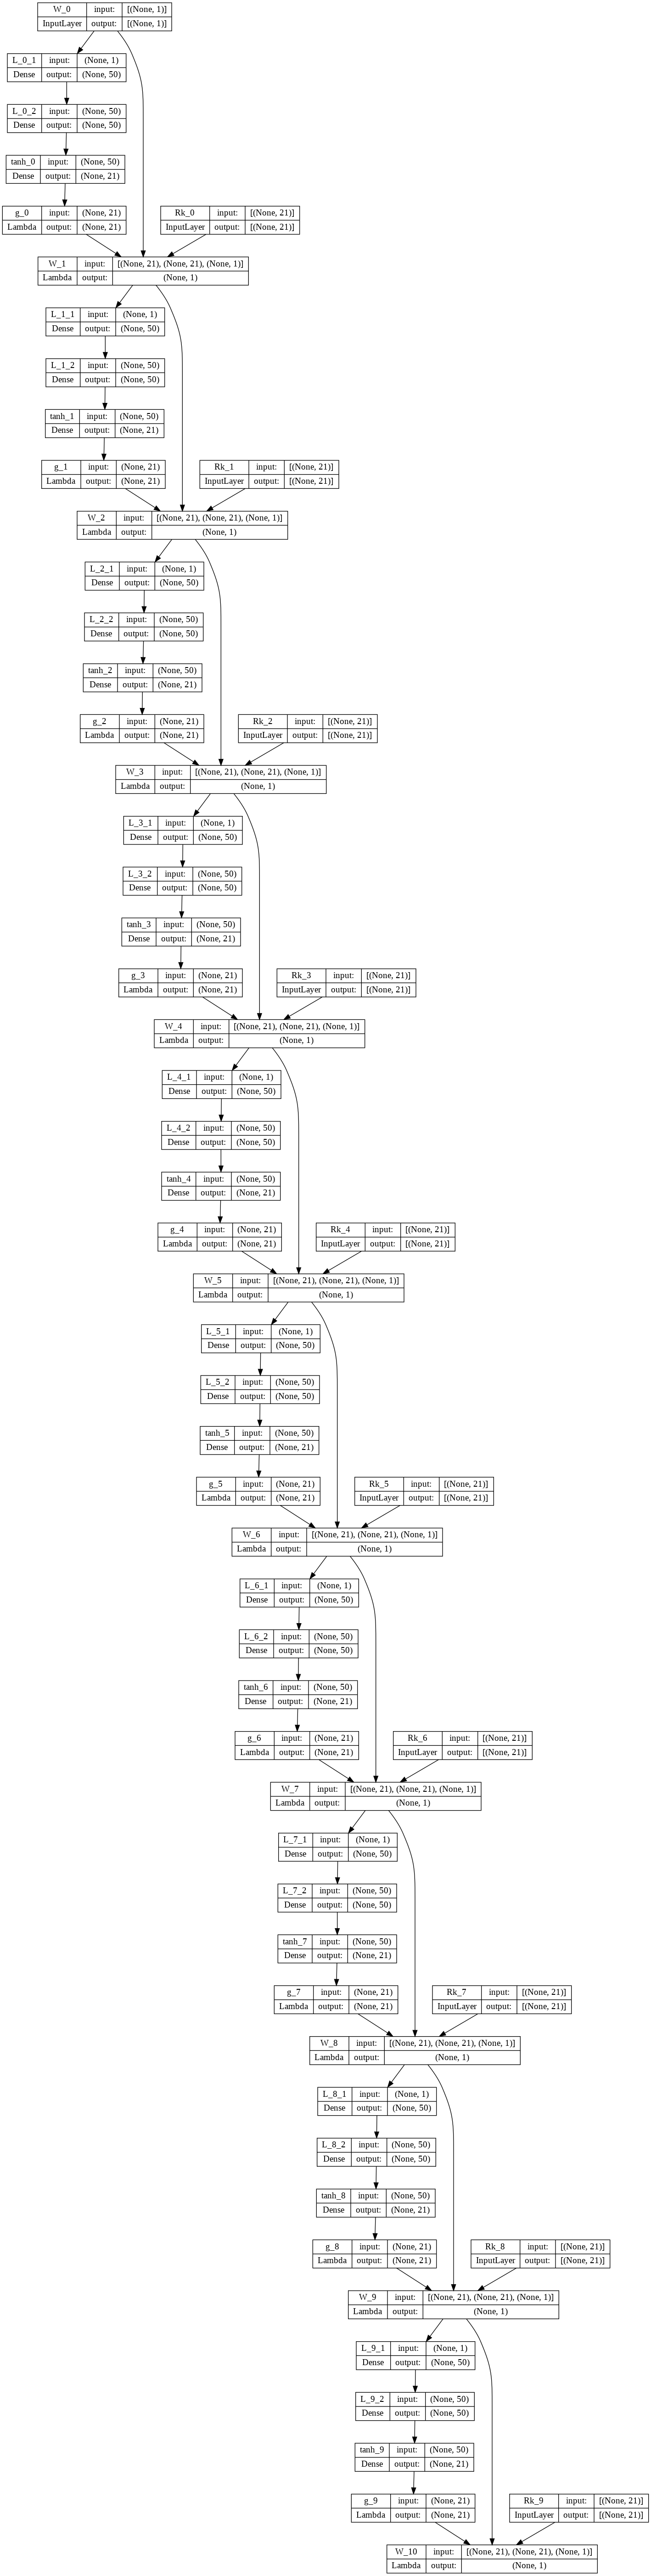

In [ ]:
keras.utils.plot_model(m_CCC_1, show_shapes=True)

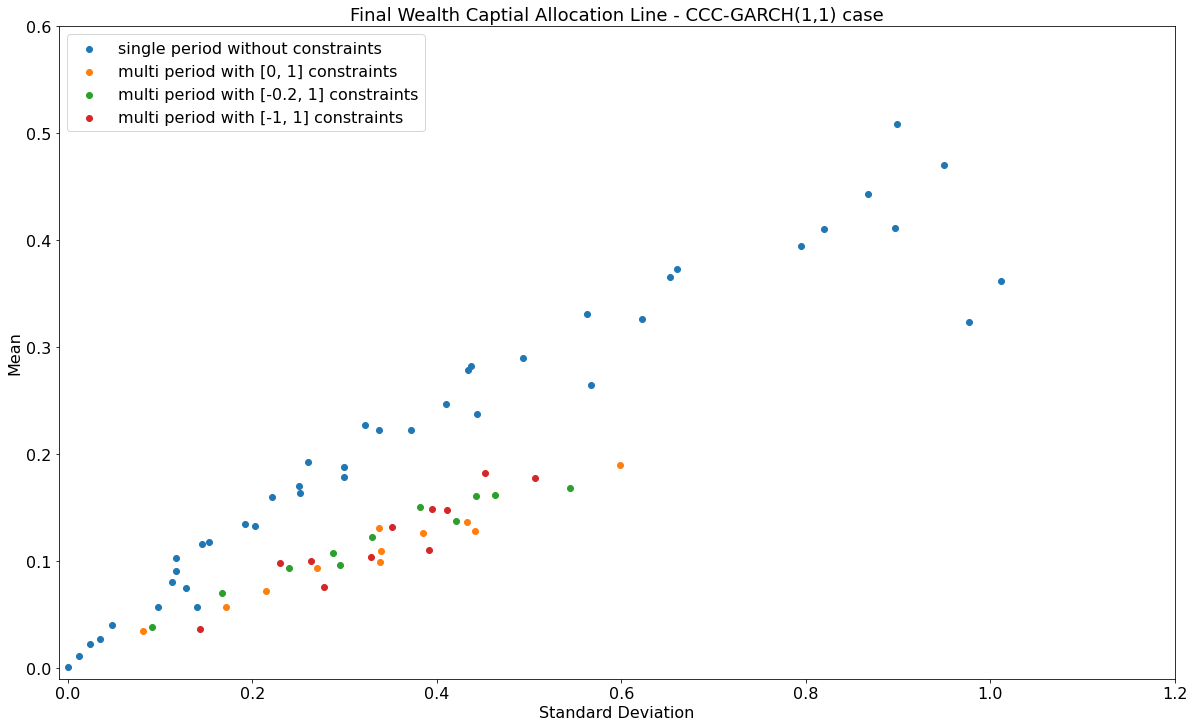

In [ ]:
fig =  plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(single_CCC_no["std"], single_CCC_no["mean"], label = "single period without constraints")
#ax.scatter(single_CCC_con["std"], single_CCC_con["mean"], label = "single period with [0, 1] constraints")
ax.scatter(multi_CCC1["std"], multi_CCC1["mean"], label = "multi period with [0, 1] constraints")
ax.scatter(multi_CCC2["std"], multi_CCC2["mean"], label = "multi period with [-0.2, 1] constraints")
ax.scatter(multi_CCC3["std"], multi_CCC3["mean"], label = "multi period with [-1, 1] constraints")
plt.xlabel("Standard Deviation", fontsize = 16)
plt.ylabel("Mean", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
xlim = ax.get_xlim()
ax.set_xlim(-0.01, 1.2)
ax.set_ylim(-0.01, 0.6)
plt.title("Final Wealth Captial Allocation Line - CCC-GARCH(1,1) case", fontsize = 18);

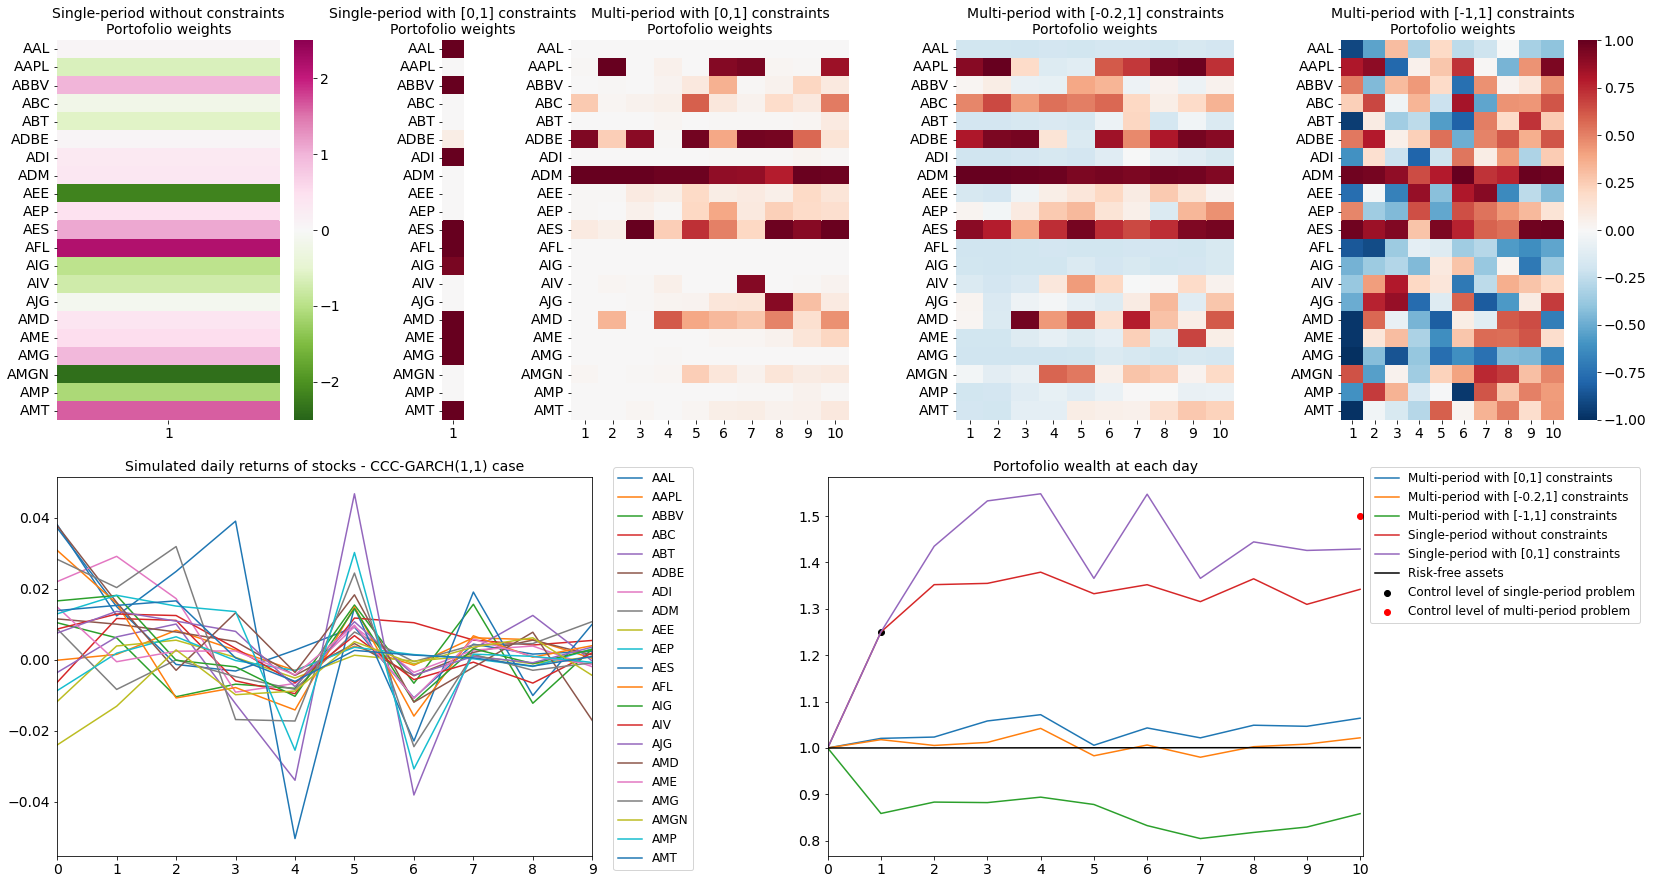

In [ ]:
# Display transition matrix
fig = plt.figure(figsize=(28, 15));
plt.subplots_adjust(wspace=5);
plt.subplots_adjust(hspace=0.15);

ax4 = plt.subplot2grid((2, 13), (0, 0), colspan=3)
sns4 = sns.heatmap(data=weights_s_CCC_no.T, vmin=-2.5, vmax=2.5, ax=ax4, cmap ="PiYG_r")
cbar1 = sns4.collections[0].colorbar
cbar1.ax.tick_params(labelsize=14)
ax4.set_title('Single-period without constraints\nPortofolio weights', fontsize=14)
ax4.set_yticklabels(tickers, rotation=0, fontsize=14)
plt.xticks(ticks = [0.5], labels = [1], fontsize=14);

ax5 = plt.subplot2grid((2, 13), (0, 3), colspan=1)
sns5 = sns.heatmap(data=weights_s_CCC_con.T, vmin=-1, vmax=1, ax=ax5, cmap ="RdBu_r", cbar=False)
ax5.set_title('Single-period with [0,1] constraints\nPortofolio weights', fontsize=14)
ax5.set_yticklabels(tickers, rotation=0, fontsize=14)
plt.xticks(ticks = [0.5], labels = [1], fontsize=14);

ax1 = plt.subplot2grid((2, 13), (0, 4), colspan=3)
sns1 = sns.heatmap(data=weights_CCC_m_1.reshape(10, 21).T, vmin=-1, vmax=1, ax=ax1, cmap ="RdBu_r", cbar=False)
ax1.set_title('Multi-period with [0,1] constraints\nPortofolio weights', fontsize=14)
ax1.set_yticklabels(tickers, rotation=0, fontsize=14)
plt.xticks(ticks = np.arange(0.5, 10.5, 1), labels = [str(i) for i in range(1,11)], fontsize=14);

ax2 = plt.subplot2grid((2, 13), (0, 7), colspan=3)
sns2 = sns.heatmap(data=weights_CCC_m_2.reshape(10, 21).T, vmin=-1, vmax=1, ax=ax2, cmap ="RdBu_r", cbar=False)
ax2.set_title('Multi-period with [-0.2,1] constraints\nPortofolio weights', fontsize=14)
ax2.set_yticklabels(tickers, rotation=0, fontsize=14)
plt.xticks(ticks = np.arange(0.5, 10.5, 1), labels = [str(i) for i in range(1,11)], fontsize=14);

ax3 = plt.subplot2grid((2, 13), (0, 10), colspan=3)
sns3 = sns.heatmap(data=weights_CCC_m_3.reshape(10, 21).T, vmin=-1, vmax=1, ax=ax3, cmap ="RdBu_r")
cbar2 = sns3.collections[0].colorbar
cbar2.ax.tick_params(labelsize=14)
ax3.set_title('Multi-period with [-1,1] constraints\nPortofolio weights', fontsize=14)
ax3.set_yticklabels(tickers, rotation=0, fontsize=14)
plt.xticks(ticks = np.arange(0.5, 10.5, 1), labels = [str(i) for i in range(1,11)], fontsize=14);

ax6 = plt.subplot2grid((2, 13), (1, 0), colspan=5)
plot_r = pd.DataFrame(rn.T.reshape(21,10).T, columns = tickers)
for stock in list(plot_r.columns):
    ax6.plot(plot_r.index, plot_r[stock], label = stock);
ax6.set_title('Simulated daily returns of stocks - CCC-GARCH(1,1) case', fontsize=14)
ax6.set_xlim(0,9)
plt.yticks(fontsize=14);
plt.xticks(fontsize=14);
plt.legend(bbox_to_anchor=(1.2, 1.04), loc="upper right", fontsize=12);

ax7 = plt.subplot2grid((2, 13), (1, 6), colspan=5)
ax7.plot(np.arange(0,11), [1] + list(ws_CCC_m_1.flatten()), label = "Multi-period with [0,1] constraints");
ax7.plot(np.arange(0,11), [1] + list(ws_CCC_m_2.flatten()), label = "Multi-period with [-0.2,1] constraints");
ax7.plot(np.arange(0,11), [1] + list(ws_CCC_m_3.flatten()), label = "Multi-period with [-1,1] constraints");
ax7.plot(np.arange(0,11), ws_s_CCC_no.flatten(), label = "Single-period without constraints");
ax7.plot(np.arange(0,11), ws_s_CCC_con.flatten(), label = "Single-period with [0,1] constraints");
ax7.plot(np.arange(0,11), [np.exp(0.03/360)**i for i in range(11)], label = "Risk-free assets", c="k");
ax7.scatter(1, 1.25, label = "Control level of single-period problem", c = "k")
ax7.scatter(10, 1.5, label = "Control level of multi-period problem", c = "r")
ax7.set_title('Portofolio wealth at each day', fontsize=14)
ax7.set_xlim(0,10.05)
plt.yticks(fontsize=14);
plt.xticks(np.arange(0,11),fontsize=14)
plt.legend(bbox_to_anchor=(1.53, 1.04), loc="upper right", fontsize=12);